In [1]:
%matplotlib inline 
import numpy as np 
from matplotlib import pyplot as plt 
import h5py # used in the Data Visualization section 

from astropy.io import fits,ascii,votable
from astropy import units as u 
from astropy import constants as const
from astropy import table
from astropy.cosmology import Planck15,FlatLambdaCDM

# For ML application
from sklearn.cluster import KMeans
from sklearn import mixture
from itertools import combinations
import pandas

In [2]:
# Specify the version of the catalog and the folder with the input/output files
catversion = 'Farmer'  # this string can be either 'Classic' or 'Farmer'
dir_in = '/Users/gabriel/Documents/N3_code/COSMOS2020.R1_v2.2-nochi2/'  
dir_out = 'experiment_notebook_output/'  # the directory where the output of this notebook will be stored

In [3]:
# Chose the SED fitting code: 
# set to 'lp' for LePhare results or
# set to 'ez' for EAZY
fitversion = 'ez'  

In [4]:
# Which type of photometric estimates to use? (suffix of the column name)
# This choice must be consistent with `catversion`,
# choices for Classic are: '_FLUX_APER2', '_FLUX_APER3', '_MAG_APER2,', '_MAG_APER3'
# choices for Farmer are '_FLUX' or '_MAG' 
flx = '_FLUX'  
flxerr = '_FLUXERR'  # catalog column for flux/mag error, just add 'ERR'
outflx = 'cgs' # 'cgs' or 'uJy'

There are several pararemeters regarding the telescope filters used for observations. They are collectively stored in a dictionary. 

In [5]:
# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4']  
filt_lambda = [0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796] 
# corresponding MW attenuation from Schelgel 
AlambdaDivEBV = [8.31,8.742,4.807,4.674,3.69,2.715,2.0,1.515,1.298,1.213,0.874,0.565,0.365,4.261,3.844,3.622,3.425,3.265,2.938,2.694,2.431,2.29,2.151,1.997,1.748,2.268,1.787,0.946,4.041,3.738,3.128,2.673,2.003,1.436,1.466,0.163,0.112,0.075,0.045]
# photometric offsets (not available for all filters, see Table 3 in W+21)
zpoff1 = [0.000,-0.352,-0.077,-0.023,0.073,0.101,0.038,0.036,0.086,0.054,0.017,-0.045,0.000,-0.104,-0.044,-0.021,-0.018,-0.045,-0.084,0.005,0.166,-0.023,-0.034,-0.032,-0.069,-0.010,-0.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.212,-0.219,0.000,0.000]  # Farmer+LePhare
zpoff2 = [0.000,-0.029,-0.006,0.053,0.128,0.127,0.094,0.084,0.100,0.049,0.025,-0.044,0.000,-0.013,-0.008,0.022,0.025,0.033,-0.032,0.031,0.208,-0.009,0.003,-0.015,-0.001,0.023,-0.021,-0.017,-0.075,0.000,0.123,0.035,0.051,0.000,0.095,-0.087,-0.111,0.000,0.000]  # Classic+LePhare
zpoff3 = [0.000,0.000,-0.196,-0.054,0.006,0.090,0.043,0.071,0.118,0.078,0.047,-0.034,0.000,-0.199,-0.129,-0.084,-0.073,-0.087,-0.124,0.004,0.154,-0.022,-0.030,-0.013,-0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.102,-0.044,0.000,0.000] # Farmer+EAZY
zpoff4 = [0.000,0.000,0.000,-0.021,0.055,0.124,0.121,0.121,0.145,0.085,0.057,-0.036,0.000,-0.133,-0.098,-0.046,-0.037,-0.038,-0.062,0.038,0.214,0.024,0.022,0.01,0.022,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.021,0.025,0.000,0.000] # Classic+EAZY
# create the dictionary
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4,AlambdaDivEBV[i],[zpoff1[i],zpoff2[i],zpoff3[i],zpoff4[i]]) for i in range(len(filt_name))}

--------------------
## Data preparation

This section includes corrections due to Milky Way foreground extinction, photometric offsets, and flux loss in case of aperture photometry. Here, a subsample of the catalogue (either by rows or columns) can also be selected, and the table re-formatted to be saved as a different file.

In [6]:
# Upload the main catalogue
cat0 = table.Table.read(dir_in+'COSMOS2020_{}_R1_v2.2_p3.fits'.format(catversion.upper()),format='fits',hdu=1)

In [7]:
# Create a mask to restrict the analysis to a subset of filters (optional)
# filt_use = ['CFHT_ustar', 'CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2']
# filt_mask = [i in filt_use for i in filt_name]

#to turn off filter:
filt_use = ['CFHT_ustar', 'CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2']
filt_mask = []

In [8]:
# Have a quick look inside the table
cat0[[0,-1]]
cat0.columns

<TableColumns names=('ID','ALPHA_J2000','DELTA_J2000','X_MODEL','Y_MODEL','ERRX_MODEL','ERRY_MODEL','ALPHA_DETECTION','DELTA_DETECTION','FARMER_ID','GROUP_ID','N_GROUP','MODEL_FLAG','SOLUTION_MODEL','FLAG_HSC','FLAG_SUPCAM','FLAG_UDEEP','FLAG_UVISTA','FLAG_COMBINED','EBV_MW','CFHT_u_FLUX','CFHT_u_FLUXERR','CFHT_u_MAG','CFHT_u_MAGERR','CFHT_u_CHISQ','CFHT_u_DRIFT','CFHT_u_VALID','CFHT_ustar_FLUX','CFHT_ustar_FLUXERR','CFHT_ustar_MAG','CFHT_ustar_MAGERR','CFHT_ustar_CHISQ','CFHT_ustar_DRIFT','CFHT_ustar_VALID','HSC_g_FLUX','HSC_g_FLUXERR','HSC_g_MAG','HSC_g_MAGERR','HSC_g_CHISQ','HSC_g_DRIFT','HSC_g_VALID','HSC_r_FLUX','HSC_r_FLUXERR','HSC_r_MAG','HSC_r_MAGERR','HSC_r_CHISQ','HSC_r_DRIFT','HSC_r_VALID','HSC_i_FLUX','HSC_i_FLUXERR','HSC_i_MAG','HSC_i_MAGERR','HSC_i_CHISQ','HSC_i_DRIFT','HSC_i_VALID','HSC_z_FLUX','HSC_z_FLUXERR','HSC_z_MAG','HSC_z_MAGERR','HSC_z_CHISQ','HSC_z_DRIFT','HSC_z_VALID','HSC_y_FLUX','HSC_y_FLUXERR','HSC_y_MAG','HSC_y_MAGERR','HSC_y_CHISQ','HSC_y_DRIFT','HSC_y_VAL

### Flags (rows selection)

Flags are used to (de-)select certain areas of the $2\,deg^2$ COSMOS field. For example, by imposing `FLAG_HSC`equal to zero, only objects within the effective area of Subaru/HyperSuprimeCam are selected (i.e., observed by HSC and outside bright star regions). 

The **most important flag** is `FLAG_COMBINED` to remove areas with either unreliable photometry or partial coverage. We strongly recommend to set `FLAG_COMBINED==0` before starting your analysis. 

Please also note that the format of photometric columns (fluxes, magnitudes) is  **masked columns**, useful to single out certain entries from the table.

In [10]:
whichflag = 'COMBINED'  # you can try HSC, SUPCAM, UVISTA, UDEEP, COMBINED
print('The parent sample includes {} sources'.format(len(cat0)))
cat0 = cat0[cat0['FLAG_{}'.format(whichflag)]==0]
print('Now restricted to {} sources by using FLAG_COMBINED'.format(len(cat0)))

The parent sample includes 964506 sources
Now restricted to 746976 sources by using FLAG_COMBINED


### Correcting for MW extinction

The following two cells remove the foreground extinction by the Milky Way (MW).

In [11]:
def mw_corr(tab_in,f_dict,ebv_col='EBV_MW',flx_col='_FLUX',flxerr_col='_FLUXERR',only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    ebv_col : name of the `tab_in` column containing the E(B-V) from Milky Way
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """
    
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    for c in ff:
        if verbose: print('remove MW attenuation in ',c+flx_col,f_dict[c][2])
        if c not in skip_filt:
            atten = f_dict[c][2]*tab[ebv_col]
            if flux:    tab[c+flx_col] *= np.power(10.,0.4*atten)
            else:    tab[c+flx_col] -= atten             
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab

In [12]:
# Here, the function creates a new table but
# it is also possible to overwrite the original table `cat0`
if catversion.lower()=='classic' and flx!='_FLUX' and flx!='_MAG':  
    # it means you are using aperture or AUTO flux/mag, which are not available for IRAC and GALEX 
    cat1 = mw_corr(cat0,filt_dict,flx_col=flx,flxerr_col=flxerr,only_filt=filt_use,skip_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'],out=True) # fluxes are  in uJy (zero point = 23.9)
    # therefore, IRAC and GALEX have to be taken into account separately:
    mw_corr(cat1,filt_dict,flx_col='_FLUX',flxerr_col='_FLUXERR',only_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV']) 
else:
    # otherwise, all filters have the same suffix
    cat1 = mw_corr(cat0,filt_dict,flx_col=flx,flxerr_col=flxerr,only_filt=filt_use,out=True)  # all bands have same column suffix

### Correcting for aperture-to-total flux

Circular aperture flux, available only in the *Classic* catalog, can be converted to total flux using a rescaling factor derived for each source from its APER-to-AUTO ratio.

In [13]:
def aper_to_tot(tab_in,f_dict,flx_col='_FLUX',flxerr_col='_FLUXERR',scale_col='',out_col=None,only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info 
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    scale_col : name of the `tab_in` column containing the aper-to-total correction
    out_col : if defined, the rescaled photometry will be saved in a new column (otherwise it overwrites `flx_col`)
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`  
    """
    
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in 
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    for c in ff:
        if c not in skip_filt:

            if verbose and flux: print('rescale {} to total flux'.format(c+flx_col))
            if verbose and not flux: print('rescale {} to total mag'.format(c+flx_col))

            if flux:
                resc = np.power(10.,-0.4*tab[scale_col])
                if out_col:
                    tab[c+out_col] = tab[c+flx_col] * resc
                    tab[c+out_col+'ERR'] = tab[c+flxerr_col] * resc  # rescale also error bars not to alter the S/N ratio
                else:
                    tab[c+flx_col] *= resc
                    tab[c+flxerr_col] *= resc
            else:
                if out_col:
                    tab[c+out_col] = tab[c+flx_col] + tab[scale_col] 
                else:
                    tab[c+flx_col] += tab[scale_col]             
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab
    

In [14]:
# Can be applied only to aperture photometry (not to AUTO or Farmer)
if (flx[-1]=='2' or flx[-1]=='3'):
    aper_to_tot(cat1,filt_dict,flx_col=flx,flxerr_col=flxerr,out_col='_FLUX',
    only_filt=filt_use,skip_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'],
    scale_col='total_off'+flx[-1],verbose=True)


### Correcting for photometric offset 

These are the systematic offsets in flux found by either `LePhare` or `EAZY` by using the COSMOS spectroscopic sample. They depend on the photometry (rescaled aperture-to-total photometry *Classic*, or the total photometry in *Farmer*) and on the SED fitting code (*LePhare* or *EAZY*). This correction has not been calculated for the AUTO fluxes in *Classic*. In the following we consider *LePhare* as a reference, whose prefix in the catalogue is `lp_` (e.g., `lp_zBEST`). *EAZY* prefix is `ez_`. 

In [15]:
def photo_corr(tab_in,f_dict,versions=('Farmer','lp'),flx_col='_FLUX',only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    ebv_col : name of the `tab_in` column containing the E(B-V) from Milky Way
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    
    if versions[0]=='Farmer' and versions[1]=='lp': v=0
    elif versions[0]=='Farmer' and versions[1]=='ez': v=1
    elif versions[0]=='Classic' and versions[1]=='lp': v=2
    elif versions[0]=='Classic' and versions[1]=='ez': v=3
    else: 
        print("ERROR: is this catalog version real?", version)
        return
    
    for c in ff:
        if verbose: print(' apply photometric offset to ',c+flx_col)
        offset = f_dict[c][3][v]
        if c not in skip_filt and offset!=0.:
            if flux:  tab[c+flx_col] *= np.power(10.,-0.4*offset)
            else:  tab[c+flx_col] += offset              
        else:
            if verbose: print('Skip filter',c)       
    if out: return tab

In [16]:
photo_corr(cat1,filt_dict,only_filt=filt_use,versions=(catversion,fitversion))

### Final formatting

Define a new astropy table `cat` which will be used in the rest of this Notebook.

Before saving the new table, remove from the catalogue the columns that are not used. Also convert flux units, and add AB magnitudes.

In [17]:
cat = cat1.copy()  

In [18]:
# optional: keep only the most commonly used columns (total FLUX, error bars, RA, DEC...)
cat.keep_columns(['ID','ALPHA_J2000','DELTA_J2000']+
                 [i+'_FLUX' for i in filt_use]+[i+'_FLUXERR' for i in filt_use]+
                 ['lp_zBEST','lp_model','lp_age','lp_dust','lp_Attenuation','lp_zp_2','lp_zq','lp_type']+
                 ['lp_MNUV','lp_MR','lp_MJ','lp_mass_med','lp_mass_med_min68','lp_mass_med_max68','lp_SFR_med','lp_mass_best']+ 
                 ['ez_restU','ez_restU_err','ez_restB','ez_restB_err','ez_restV','ez_restV_err','ez_restJ','ez_restJ_err'])

In [19]:
# optional: magnitudes in AB system
m0 = +23.9  # fluxes in the catalog are in microJansky
for b in filt_use:
    mag = -2.5*np.log10(cat[b+'_FLUX'].data) + m0  # log of negative flux is masked
    cat.add_column(mag.filled(np.nan),name=b+'_MAG')  # negative flux becomes NaN 

/var/folders/8b/l2p6wkt967l9p1j0h6q4yw9m0000gn/T/ipykernel_18153/706566923.py:4: RuntimeWarning: invalid value encountered in log10
  mag = -2.5*np.log10(cat[b+'_FLUX'].data) + m0  # log of negative flux is masked


In [20]:
# flux conversion from uJy to erg/cm2/s/Hz
if outflx=='cgs':
    for b in filt_use:
        cat[b+'_FLUX'] *= 1e-29
        cat[b+'_FLUX'].unit = u.erg/u.cm/u.cm/u.s/u.Hz
        cat[b+'_FLUXERR'] *= 1e-29
        cat[b+'_FLUXERR'].unit = u.erg/u.cm/u.cm/u.s/u.Hz

One may want to **rename some columns** in a more user-friendly fashion. For example, the reference photo-z estimates (the ones to use in most of the cases) are originally named `lp_zBEST` for *LePhare* and `ez_z_phot` for *EAZY*. Once chosen the version, it is convenient to change the correspondent column to a standard name (e.g., `photoz`) so that the rest of the Notebook will work either way.  

In [21]:
cat.rename_column('lp_zBEST', 'photoz') 
cat.rename_column('ALPHA_J2000','RA')
cat.rename_column('DELTA_J2000','DEC')

In [22]:
# Save the re-formatted table as a FITS file. 
cat.write(dir_out+'COSMOS2020_{}_processed.fits'.format(catversion),overwrite=True)

In [23]:
# searchfield = cat[(cat['photoz']<=0.6) && ([cat['photoz'] >= 0.5])]
searchfield = cat[(cat['photoz']<=0.6) & (cat['photoz']>=0.55667)]
searchfield

ID,RA,DEC,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_ustar_FLUX,CFHT_ustar_FLUXERR,HSC_g_FLUX,HSC_g_FLUXERR,HSC_r_FLUX,HSC_r_FLUXERR,HSC_i_FLUX,HSC_i_FLUXERR,HSC_z_FLUX,HSC_z_FLUXERR,HSC_y_FLUX,HSC_y_FLUXERR,UVISTA_Y_FLUX,UVISTA_Y_FLUXERR,UVISTA_J_FLUX,UVISTA_J_FLUXERR,UVISTA_H_FLUX,UVISTA_H_FLUXERR,UVISTA_Ks_FLUX,UVISTA_Ks_FLUXERR,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,photoz,lp_type,lp_zp_2,lp_zq,lp_model,lp_age,lp_dust,lp_Attenuation,lp_MNUV,lp_MR,lp_MJ,lp_mass_med,lp_mass_med_min68,lp_mass_med_max68,lp_mass_best,lp_SFR_med,ez_restU,ez_restU_err,ez_restB,ez_restB_err,ez_restV,ez_restV_err,ez_restJ,ez_restJ_err,CFHT_ustar_MAG,CFHT_u_MAG,HSC_g_MAG,HSC_r_MAG,HSC_i_MAG,HSC_z_MAG,HSC_y_MAG,UVISTA_Y_MAG,UVISTA_J_MAG,UVISTA_H_MAG,UVISTA_Ks_MAG,IRAC_CH1_MAG,IRAC_CH2_MAG
,deg,deg,erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),erg / (Hz s cm2),,,,,,yr,,,mag,mag,mag,log(solMass),log(solMass),log(solMass),log(solMass),log(solMass/yr),uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
17,150.4757193572789,2.333081930539043,8.368145035833505e-31,4.111420408254105e-32,9.0691060399348e-31,3.4859791793167357e-32,7.3768883951838475e-31,3.2805098062630306e-32,7.227763719130863e-31,4.696112198110405e-32,7.58413131658177e-31,4.4625625451961515e-32,9.123892293465841e-31,6.688396231251248e-32,6.851727926800602e-31,1.4661279655305595e-31,3.406045092204144e-30,1.0307552854766895e-31,1.2508268856547062e-30,1.2200519738940098e-31,5.884477053083092e-31,1.5362043169053946e-31,1.2064297960685068e-30,2.0640874681238424e-31,-1.053498193161979e-30,1.0544690004731174e-31,-1.1606692464855964e-30,9.03009501579847e-32,0.5725,0,--,0.0,10,50000000.0,0.1,0,-15.66295,-16.56777,-15.92039,6.6407,6.60661,6.68056,6.69292,-0.70023,--,--,--,--,--,--,--,--,26.50608880028185,26.59342700316012,26.730316967313943,26.752490133206276,26.70023538986949,26.499549625408008,26.810499726582112,25.06937401691284,26.157006981176707,26.975730315930583,26.196244863142947,nan,nan
43,149.463199020437,1.6250610544252697,2.745922018551525e-31,4.194816745868463e-32,1.6580440136723393e-31,7.672576201831106e-32,3.3009208332223045e-31,4.3775165801609155e-32,1.139928013839383e-30,6.912354115895763e-32,2.032718084933589e-30,7.543582038998941e-32,2.7012363140169173e-30,1.1367507333986187e-31,3.0585686503857182e-30,2.935351052613259e-31,3.278118593406056e-30,1.30606389799563e-31,3.689184626281792e-30,1.4432718432768988e-31,3.3526836799093796e-30,2.002527182201697e-31,4.132194368264641e-30,2.9806572667289085e-31,4.379765778706766e-30,2.7570853828333653e-31,3.794518623337412e-30,4.442694294897336e-31,0.581,0,--,0.59,2,1278000000.0,0.0,0,-14.31334,-16.9608,-17.23857,8.3104,8.22876,8.49622,8.1999,-1.25765,0.08400761,0.0027581602,0.18817344,0.0052883103,0.26531333,0.0059078187,0.39762056,0.022865072,28.351009862628842,27.803279501136405,27.603412228334317,26.257806433455833,25.62980712232698,25.32109355120835,25.18620441800446,25.110938347223296,24.982674024599707,25.086518548988543,24.859548146317955,24.796372785232368,24.952108278333277
54,150.72298645696668,2.543470338506238,2.2228009225541314e-31,4.326733114859

##### compute colors
searchfield['u-b'] = searchfield['ez_restU'] - searchfield['ez_restB']
searchfield['b-v'] = searchfield['ez_restB'] - searchfield['ez_restV']
searchfield['v-j'] = searchfield['ez_restV'] - searchfield['ez_restJ']

colors = searchfield['u-b', 'b-v', 'v-j']
colors

In [24]:
# #compute colors - legacy SED method
# searchfield['u-b'] = searchfield['ez_restU'] - searchfield['ez_restB']
# searchfield['b-v'] = searchfield['ez_restB'] - searchfield['ez_restV']
# searchfield['v-j'] = searchfield['ez_restV'] - searchfield['ez_restJ']

# colors = searchfield['u-b', 'b-v', 'v-j']
# colors

# interesting filters
# HSC_g, HSC_r, HSC_i, HSC_z, HSC_y

# CFHT_u

# UVISTA_Y, UVISTA_J, UVISTA_H, UVISTA_Ks

#compute colors - granular telescope measurement
searchfield['HSC_g-r'] = searchfield['HSC_g_FLUX'] - searchfield['HSC_r_FLUX']
searchfield['HSC_r-i'] = searchfield['HSC_r_FLUX'] - searchfield['HSC_i_FLUX']
searchfield['HSC_i-z'] = searchfield['HSC_y_FLUX'] - searchfield['HSC_z_FLUX']
searchfield['HSC_z-y'] = searchfield['HSC_z_FLUX'] - searchfield['HSC_y_FLUX']
searchfield['HSC_y-g'] = searchfield['HSC_y_FLUX'] - searchfield['HSC_g_FLUX']

searchfield['CFHT_u'] = searchfield['CFHT_u_FLUX']

searchfield['UVISTA_y-j'] = searchfield['UVISTA_Y_FLUX'] - searchfield['UVISTA_J_FLUX']
searchfield['UVISTA_j-h'] = searchfield['UVISTA_J_FLUX'] - searchfield['UVISTA_H_FLUX']
searchfield['UVISTA_h-Ks'] = searchfield['UVISTA_H_FLUX'] - searchfield['UVISTA_Ks_FLUX']
searchfield['UVISTA_Ks-y'] = searchfield['UVISTA_Ks_FLUX'] - searchfield['UVISTA_Y_FLUX']

colors = searchfield['HSC_g-r','HSC_r-i','HSC_i-z','HSC_z-y','HSC_y-g','CFHT_u','UVISTA_y-j','UVISTA_j-h','UVISTA_h-Ks','UVISTA_Ks-y'] 
colors

HSC_g-r,HSC_r-i,HSC_i-z,HSC_z-y,HSC_y-g,CFHT_u,UVISTA_y-j,UVISTA_j-h,UVISTA_h-Ks,UVISTA_Ks-y
uJy,uJy,uJy,uJy,uJy,erg / (Hz s cm2),uJy,uJy,uJy,uJy
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.491246760529848e-32,-3.563675974509073e-32,-2.272164366665239e-31,2.272164366665239e-31,-5.251604683832458e-32,8.368145035833505e-31,2.1552182065494378e-30,6.623791803463971e-31,-6.179820907601976e-31,-2.1996152961356373e-30
-8.098359305171525e-31,-8.92790071094206e-31,3.5733233636880087e-31,-3.5733233636880087e-31,2.7284765670634877e-30,2.745922018551525e-31,-4.110660328757364e-31,3.3650094637241272e-31,-7.795106883552611e-31,8.540757748585848e-31
-1.2179426067658734e-30,-1.3775632881493608e-30,4.832715771309754e-31,-4.832715771309754e-31,4.1977652420907584e-30,2.2228009225541314e-31,-3.426472024659585e-30,-2.169078588672202e-31,6.745062779089165e-31,2.968873605617889e-30
-8.811414739329855e-32,-1.656092665783682e-31,-3.483345415407194e-31,3.483345415407194e-31,7.121467858208471e-32,-4.300985407085678e-33,-1.5732470589893845e-31,-1.0557302727756328e-30,6.176963833815185e-31,5.9535859529305266e-31
1.8199468166707943e-32,-1.2707629181528446e-31,2.290119385577508e-31,-2.290119385577508e-31,3.8969415363457455e-31,2.5786418032839154e-32,-2.7391604931523153e-31,-3.2728979166863467e-31,-4.0887819653956806e-32,6.42093660637823e-31
-1.0368332215547498e-30,-1.3335440099751387e-30,3.301685135514735e-31,-3.301685135514735e-31,3.720590253333986e-30,6.216118978040415e-31,-1.3027664585670888e-30,-4.085061737159047e-31,-1.2637480617055029e-30,2.9750206939884964e-30
-8.87744684360389e-31,-1.1585367697712896e-30,2.842983625355372e-31,-2.842983625355372e-31,3.521934405716487e-30,2.4633773157345563e-31,-1.5315179472289893e-30,-3.199420967861924e-31,2.3526093699121247e-30,-5.01149325896943e-31
-4.0069476448133305e-30,-2.7296392878246267e-30,5.592517531639552e-31,-5.592517531639552e-31,7.627923344975126e-30,4.62990181777813e-30,1.5979263883384357e-32,-9.527686726832945e-31,7.198967322264605e-31,2.1689267657344964e-31


In [25]:
colors_pandas = colors.to_pandas()
colors_pandas.isnull().sum

<bound method DataFrame.sum of        HSC_g-r  HSC_r-i  HSC_i-z  HSC_z-y  HSC_y-g  CFHT_u  UVISTA_y-j  \
0        False    False    False    False    False   False       False   
1        False    False    False    False    False   False       False   
2        False    False    False    False    False   False       False   
3        False    False    False    False    False   False       False   
4        False    False    False    False    False   False       False   
...        ...      ...      ...      ...      ...     ...         ...   
12484    False    False    False    False    False   False       False   
12485    False    False    False    False    False   False       False   
12486    False    False    False    False    False   False       False   
12487    False    False    False    False    False   False       False   
12488    False    False    False    False    False   False        True   

       UVISTA_j-h  UVISTA_h-Ks  UVISTA_Ks-y  
0           False        False    

In [26]:
#get rid of all nulls

colors_clean_pandas = colors_pandas.dropna()
#show resulting prepared data
colors_clean = table.Table.from_pandas(colors_clean_pandas)

In [27]:
# show null/nonnull state of the data
colors_clean_pandas.isnull().sum

<bound method DataFrame.sum of        HSC_g-r  HSC_r-i  HSC_i-z  HSC_z-y  HSC_y-g  CFHT_u  UVISTA_y-j  \
0        False    False    False    False    False   False       False   
1        False    False    False    False    False   False       False   
2        False    False    False    False    False   False       False   
3        False    False    False    False    False   False       False   
4        False    False    False    False    False   False       False   
...        ...      ...      ...      ...      ...     ...         ...   
12483    False    False    False    False    False   False       False   
12484    False    False    False    False    False   False       False   
12485    False    False    False    False    False   False       False   
12486    False    False    False    False    False   False       False   
12487    False    False    False    False    False   False       False   

       UVISTA_j-h  UVISTA_h-Ks  UVISTA_Ks-y  
0           False        False    

In [28]:
#kick pandas, keep numpy
colors_clean_numpy = colors_clean_pandas.to_numpy()
colors_clean_numpy.shape

(11749, 10)


# Outlier detection with Local Outlier Factor (LOF)

The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection
method which computes the local density deviation of a given data point with
respect to its neighbors. It considers as outliers the samples that have a
substantially lower density than their neighbors. This example shows how to use
LOF for outlier detection which is the default use case of this estimator in
scikit-learn. Note that when LOF is used for outlier detection it has no
`predict`, `decision_function` and `score_samples` methods. See the `User
Guide <outlier_detection>` for details on the difference between outlier
detection and novelty detection and how to use LOF for novelty detection.

The number of neighbors considered (parameter `n_neighbors`) is typically set 1)
greater than the minimum number of samples a cluster has to contain, so that
other samples can be local outliers relative to this cluster, and 2) smaller
than the maximum number of close by samples that can potentially be local
outliers. In practice, such information is generally not available, and taking
`n_neighbors=20` appears to work well in general.


In [29]:
print(colors_clean_numpy)
colors_clean_numpy.shape

data_to_analyze = colors_clean_numpy

print("the shape of data_to_analyze is, after computation:", data_to_analyze.shape)
#a bit broken - actually nonsensical
#problem: what should a negative outlier be?
n_outliers = len(data_to_analyze)
ground_truth = np.ones(data_to_analyze.shape[0], dtype=int)
ground_truth[-n_outliers:] = -1
# ground_truth = ground_truth.reshape(117490)
print("the shape of ground_truth is, after computation:", ground_truth.shape)

[[ 1.49124676e-32 -3.56367597e-32 -2.27216437e-31 ...  6.62379180e-31
  -6.17982091e-31 -2.19961530e-30]
 [-8.09835931e-31 -8.92790071e-31  3.57332336e-31 ...  3.36500946e-31
  -7.79510688e-31  8.54075775e-31]
 [-1.21794261e-30 -1.37756329e-30  4.83271577e-31 ... -2.16907859e-31
   6.74506278e-31  2.96887361e-30]
 ...
 [-8.83581867e-32  1.51055425e-31  6.57913877e-31 ...  7.81472056e-31
  -1.55295544e-30 -7.63448984e-32]
 [-7.45171609e-31 -1.33198129e-31  7.30391172e-31 ... -2.68830838e-31
  -9.00824448e-31  1.41203707e-30]
 [-8.07802089e-31 -2.42581549e-31  9.79715161e-31 ...  1.98564667e-30
  -5.62455202e-30  3.76473242e-30]]
the shape of data_to_analyze is, after computation: (11749, 10)
the shape of ground_truth is, after computation: (11749,)


## Fit the model for outlier detection (default)

Use `fit_predict` to compute the predicted labels of the training samples
(when LOF is used for outlier detection, the estimator has no `predict`,
`decision_function` and `score_samples` methods).



In [33]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=100)
y_pred = clf.fit_predict(data_to_analyze)
n_errors = (y_pred != ground_truth).sum()
data_to_analyze_scores = clf.negative_outlier_factor_



print("the shape of y_pred is:", y_pred.shape)
print("the shape of data_to_analyze_scores is:", data_to_analyze_scores.shape)

the shape of y_pred is: (11749,)
the shape of data_to_analyze_scores is: (11749,)


In [36]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [31]:
#Iteration II: current prediction method only finds inliers. Nothing is marked as an outlier.
#I don't understand why.
y_pred[y_pred==-1]

array([], dtype=int64)

## Plot results



/var/folders/8b/l2p6wkt967l9p1j0h6q4yw9m0000gn/T/ipykernel_18153/507152115.py:14: RuntimeWarning: invalid value encountered in divide
  radius = (data_to_analyze_scores.max() - data_to_analyze_scores) / (data_to_analyze_scores.max() - data_to_analyze_scores.min())


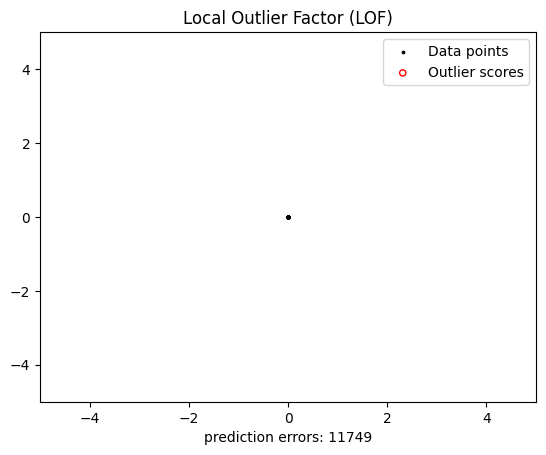

In [32]:
#a bit slow but who cares
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection


def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.scatter(data_to_analyze[:, 0], data_to_analyze[:, 1], color="k", s=3.0, label="Data points")
# plot circles with radius proportional to the outlier scores
radius = (data_to_analyze_scores.max() - data_to_analyze_scores) / (data_to_analyze_scores.max() - data_to_analyze_scores.min())
scatter = plt.scatter(
    data_to_analyze[:, 0],
    data_to_analyze[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)")
plt.show()